In [12]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.abspath(".."))

# 확인: 경로가 잘 추가되었는지 출력
print("시스템 경로 추가 완료:", os.path.abspath(".."))

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from tools.rag_tools import policy_search_tool

from IPython.display import Image, display

from core.state import NegotiationState
from cot_icl.nodes import (
    negotiator_node,
    evaluation_node,
    setup_node
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
시스템 경로 추가 완료: c:\Users\c\Desktop\workspace\Nego-interface


In [13]:
def route_to_setup_or_negotiator(state:NegotiationState):
    """
    START에서 실행될 라우터 로직
    """
    messages = state.get("messages", [])
    is_finished = state.get("is_finished", False)

    if not messages or is_finished:
        return "setup"
    
    return "negotiator"

In [ ]:
def route_after_negotiation(state: NegotiationState):
    """
    협상 노드가 끝난 후 어디로 갈지 결정
    """
    last_msg = state["messages"][-1]

    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "tools"
    
    MAX_TURNS = 10
    current_turns = len(state["messages"]) // 2
    if state.get("is_finished"):
        return "evaluator"
    
    if current_turns >= MAX_TURNS:
        return "evaluator"
    
    return END

In [17]:
def build_CoT_graph():
    workflow = StateGraph(NegotiationState)
    memory = MemorySaver()
    tools = [policy_search_tool]

    workflow.add_node("setup", setup_node)
    workflow.add_node("negotiator", negotiator_node)
    workflow.add_node("evaluator", evaluation_node)
    workflow.add_node("tools", ToolNode(tools))

    # [Start] -> [Setup] 
    workflow.add_conditional_edges(
        START,
        route_to_setup_or_negotiator,
        {
            "setup": "setup",
            "negotiator": "negotiator"
        }
    )
    
    # [Setup] -> [Negotiator]
    workflow.add_edge("setup", "negotiator")

    # [Negotiator] -> [분기점] (계속 대화 or 평가?)
    workflow.add_conditional_edges(
        "negotiator",
        route_after_negotiation,
        {
            "tools": "tools",        
            "evaluator": "evaluator",
            END: END 
        }
    )

    # [Tools] -> [Negotiator]
    workflow.add_edge("tools", "negotiator")

    # [Evaluator] -> [분기점] (성공 or 반성?)
    workflow.add_edge("evaluator", END)

    return workflow.compile(checkpointer=memory)

# 그래프 생성
app = build_CoT_graph()
print("COT + ICL 그래프 생성 완료!")

COT + ICL 그래프 생성 완료!


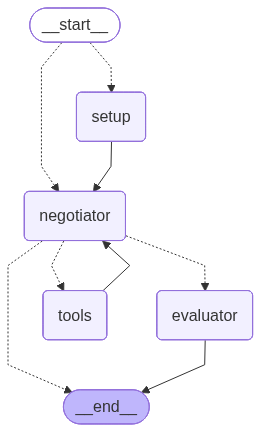

In [18]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)
    print("이미지 렌더링 실패, 텍스트로 출력합니다.")
    print(app.get_graph().draw_mermaid())